In [35]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # Настраиваем генератор маркеров и палитру
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Вывод поверхности решения
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    # предсказываем класс каждой точки для окрашивания в соответствующий цвет
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) # ravel делает массив 1D
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # показать все образцы
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)
        
    # вылелить тестовые образцы
        
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                    alpha=1.0, linewidths=1, marker='o',
                    s=55, label='Тестовый набор')

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
data = iris.data
target_names = iris.target_names
target = iris.target
feature_names = iris.feature_names



X = data[:, [2,3]] # Забираем третью и четвёртую колонки
y = target
np.unique(y) # Показывает категории

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# sc.fit(X_train) # Считает эмперическое среднее (ню) и стандартное отклонение (сигма)
# для каждой размерности признаков
# Стандартизирование значений, используя ню и сигма из предыдущего значения
# X_train_std = sc.transform(X_train) 
# X_test_std = sc.transform(X_test)   
# Если нужно меньше писать, ниже в две строчки
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_combined_std = np.vstack([X_train_std, X_test_std])
y_combined_std = np.hstack((y_train, y_test))



Опираясь на признаки в тренировочном наборе, модель дерева решений обучается серии вопросов, чтобы сделать выводы о метках классов образцов. Используя алгоритм выбора решения, мы начинаем в корне дерева и расщепляем данные по признаку, который ведёт к самому большому приросту информации (Information Gain, IG). Далее мы повторяем процедуру расщепленяи в итеративном режиме в каждом дочернем узле, пока не получим однородных листов. То есть все образцы в каждом узле принадлежат одному и тому же классу. Для глубоких деревьев возможно переобучение. Для уменьшения максимальной глубины дерева используется операция "подрезка".
Для того, чтобы расщепить узлы в самых информативных признаках, нам необходимо определить целевую функцию, которую мы хотим оптимизировать алгоритмом обучения на основе дерева.



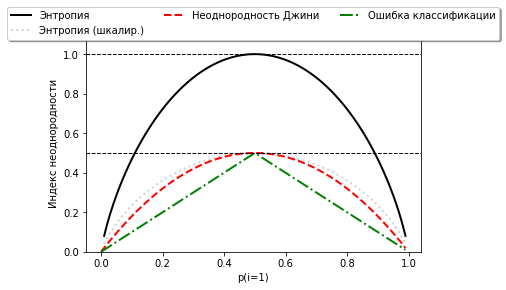

In [26]:
def gini(p):    # определяем функцию Джини
    return (p) * (1 - (p)) + (1 - p) * (1 - (1 - p))

def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
# добавляем масштабированную версию энтропии, чтобы учесть, что мера неоднородности Джини 
# является промежуточной между энтропией и ошибкой классификации
sc_ent = [e * 0.5 if e else None for e in ent] 
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err], 
                        ['Энтропия', 'Энтропия (шкалир.)', 
                         'Неоднородность Джини', 'Ошибка классификации'], 
                         ['-', 'dotted', '--', '-.'], 
                        ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Индекс неоднородности')
plt.show()


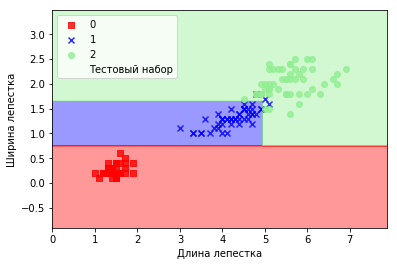

In [39]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel("Длина лепестка")
plt.ylabel("Ширина лепестка")
plt.legend(loc='upper left')
plt.show()


In [43]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', feature_names=feature_names[2:])

 # dot - Tpng tree.dot -о tree .png

# Случайный лес
Ансамбль деревьев
Алгоритм:
1. Извлечь случайную бутстрап-выборку размера n (Случайным образом отобрать из тренировочного набора данных n образцов с возвратом, то есть повторным способом)
2. Вырастить дерево решений из бутстрап-выборки. В каждом узле:
- случайным образом отобрать d признаков без возврата, т.е. бесповторным способом;
- расщепить узел, используя признак, который обеспечивает наилучшее расщепление согласно целевой функции, например, путём максимизации прироста информации;
- повторить шаги 1 и 2 k число раз;
- для назначения метки класса агрегировать прогноз из каждого дерева на основе большинства голосов.



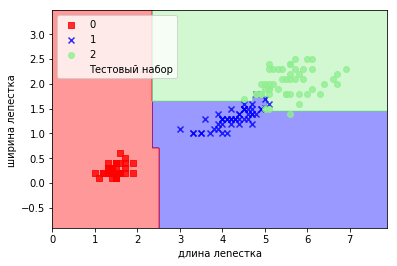

In [51]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators - количество оценщиков
forest = RandomForestClassifier(criterion='entropy',n_estimators=10, random_state=1, n_jobs=20)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('длина леnестка')
plt.ylabel('ширина лепестка ')
plt.legend(loc='upper left')
plt.show()